## Loading packages

In [1]:
import scanpy as sc 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

import scipy.sparse as sp 
import warnings
import os

warnings.filterwarnings("ignore")

os.environ["R_HOME"] = "/home/lxx/.conda/envs/r4Base/lib/R"
os.environ["R_USER"] = "/home/lxx/.local/lib/python3.9/site-packages/rpy2"

import spCLUE

spCLUE.fix_seed(0)

## Loading data

In [2]:
sample_name="151671"
n_clusters = 5 if sample_name in [str(151669 + x) for x in range(4)] else 7

data_file = f"../dataset/DLPFC/{sample_name}.h5ad"
adata = sc.read_h5ad(data_file)
adata.var_names_make_unique()
print(adata)

AnnData object with n_obs × n_vars = 4110 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'Region'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'


In [3]:
adata = spCLUE.preprocess(adata)
adata.obsm["X_pca"] = PCA(n_components=200, random_state=0).fit_transform(adata.X)
g_spatia = spCLUE.prepare_graph(adata, "spatial")
g_expr = spCLUE.prepare_graph(adata, "expr")
graph_dict = {"spatial": g_spatia, "expr":g_expr}

normalized data ---------------->
create adjacent matrix from spatial idx --------------->
create knn graph ---->
spatial knn graph created ----<
create adjacent matrix from pca expr --------------->
create knn graph ---->
expr knn graph created ----<


## train spCLUE

In [4]:
spCLUE_model = spCLUE.spCLUE(adata.obsm["X_pca"], graph_dict, n_clusters)
_, adata.obsm["spCLUE"] = spCLUE_model.train()

Training Start =========================>


 20%|█▉        | 99/500 [00:01<00:04, 88.98it/s] 

epoch 100: 0.607699771271661


In [5]:
refinement = True
cluster_method = "mclust"
pred = spCLUE.clustering(
    adata,
    n_clusters,
    key="spCLUE",
    refinement=refinement,
    cluster_methods=cluster_method,
)

R[write to console]: Package 'mclust' version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



In [6]:
adata = adata[adata.obs.Region.notna()]
ARI = adjusted_rand_score(adata.obs["Region"], adata.obs["mclust_refined"])
print(f"ARI on {sample_name}: {ARI}")

ARI on 151671: 0.8280831219244454


## visualization

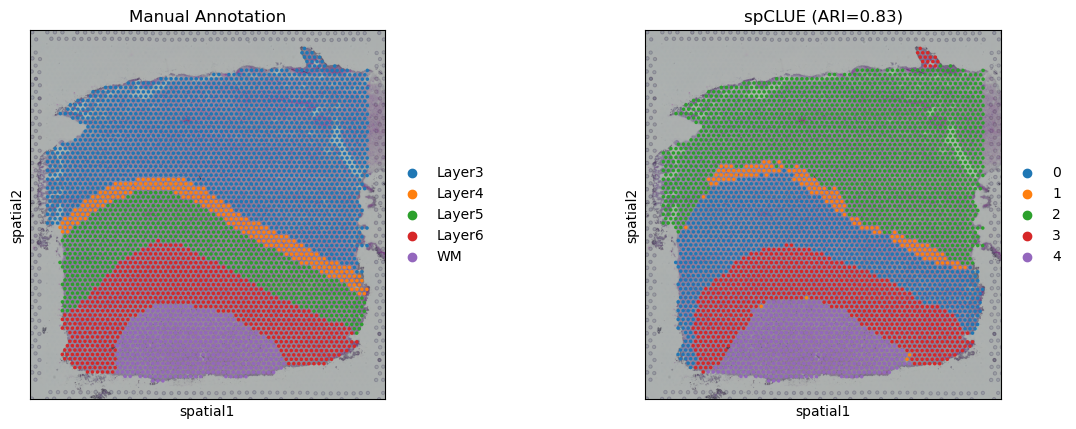

In [7]:
adata.obs["spCLUE"] = adata.obs["mclust_refined"]
sc.pl.spatial(adata, color=["Region", "spCLUE"], title=["Manual Annotation", f"spCLUE (ARI={round(ARI, 2)})"])